In [1]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
import pandas as pd
from PIL import Image
import base64
from langchain_core.messages import HumanMessage
import mimetypes
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
# from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
import dotenv
import os
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
import requests
import json
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing import Literal
dotenv.load_dotenv()


True

In [ ]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temprature = 0)


Unexpected argument 'temprature' provided to ChatGoogleGenerativeAI. Did you mean: 'temperature'?
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: WARNING! temprature is not default parameter.
                temprature was transferred to model_kwargs.
                Please confirm that temprature is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
class UniversalLoader:
    def __init__(self,llm):
        self.llm = llm

    def process_file(self, file_path: str):
        """
        Traffic Controller: Routes files to the correct reader.
        """
        # 1. Get extension and mime type
        _, ext = os.path.splitext(file_path)
        ext = ext.lower()
        mime_type, _ = mimetypes.guess_type(file_path)
        
        # 2. DEFINE CODE EXTENSIONS (Treat these as text)
        code_extensions = {'.py', '.js', '.ts', '.html', '.css', '.java', '.cpp', '.c', '.h', '.sql', '.md', '.json', '.xml', '.yaml', '.yml', '.txt'}

        if ext in code_extensions:
            return self._process_code(file_path, ext)
        
        elif mime_type and "pdf" in mime_type:
            return self._process_pdf(file_path)
        
        elif mime_type and "csv" in mime_type:
            return self._process_csv(file_path)
        
        elif mime_type and "image" in mime_type:
            return self._process_image(file_path)
        
        else:
            return f"Unsupported file type: {mime_type or ext}"
        
    def _process_code(self, file_path, ext):
        """Reads code files and wraps them in markdown."""
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
            # Wrap in markdown so LLM knows it's code
            lang_map = {'.py': 'python', '.js': 'javascript', '.ts': 'typescript', '.html': 'html', '.sql': 'sql', '.css': 'css'}
            language = lang_map.get(ext, '')
            return f"```{language}\n{content}\n```"
        except Exception as e:
            return f"Error reading code file: {e}"
        
    def _process_txt(self,file_path):
        with open(file_path,'r') as f:
            return f.read()
        
    def _process_pdf(self,file_path):
        loader = PyPDFLoader(file_path)
        pages = loader.load_and_split()
        result = ""
        for page in pages:
            result += page.page_content + "\n"
        return result
    
    def _process_csv(self,file_path):
        df = pd.read_csv(file_path)
        return df.to_markdown(index=False)
    
    def _process_image(self,file_path):
        try:
            with open(file_path, 'rb') as f:
                    
                image_data = base64.b64encode(f.read()).decode('utf-8')
                
                Prompt = HumanMessage(content = [
                    {"type":"text","text":"Describe the following image in detail."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}},
                ])
                response = self.llm.invoke([Prompt])
                return response.content

        except Exception as e:
            return "error processing image: " + str(e)
        

universalloader = UniversalLoader(model)
    
    



In [4]:
search_tool = DuckDuckGoSearchRun()
search_tool.name = "search_tool"
search_tool.description = "web search tool to find more information about a topic"
result = search_tool.invoke("where is udaipur?")
print(result)

3 weeks ago - Udaipur (Hindi: IPA: [ʊdəjpʊɾ], pronunciationⓘ) (ISO 15919: Udayapura) is a city in the north-western Indian state of Rajasthan , about 415 km (258 mi) south of the state capital Jaipur. It serves as the administrative headquarters of Udaipur district. It is the historic capital of the ... 1 week ago - Udaipur district is one of the 50 districts of Rajasthan state in western India . The historic city of Udaipur is the administrative headquarters of the district. The district is part of the Mewar region of Rajasthan. Before Udaipur district was established in independent India, it was a part ... August 31, 2025 - उदयपुर (Udaipur) भारत के राजस्थान राज्य के उदयपुर ज़िले में स्थित एक नगर है। यह राजस्थान का एक प्रमुख ... March 7, 2025 - Maharana Jagat Singh-I (1628-1652) further added more rooms to the Raaj-Mahal and further developed Jagmandir island palace and temples in the city. Over the centuries, four more water bodies were added to Pichola to its north, viz.-Amar Kund +

In [5]:
#embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
vector_store = FAISS.from_texts(["Nexus Initialized"], embeddings)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24108\4077836168.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [6]:
def index_files(file_paths):
    """
    Reads files -> Chunks them -> Saves to Vector DB (Locally)
    """
    all_documents = []
    
    for path in file_paths:
        print(f"Loading: {path}...")
        
        # Extract Text using your UniversalLoader
        raw_content = universalloader.process_file(path)
        
        # Convert to Document
        doc = Document(page_content=raw_content, metadata={"source": path})
        all_documents.append(doc)
        
    # Split into chunks
    splits = text_splitter.split_documents(all_documents)
    
    # Add to Vector Store
    if splits:
        vector_store.add_documents(splits)
        print(f"Successfully indexed {len(splits)} chunks locally!")
    else:
        print("No content found to index.")

In [7]:
with open("nexus_local_test.py", "w") as f:
    f.write("""
def secure_handshake():
    '''Local encryption protocol for Nexus'''
    return "Handshake Accepted"
""")

# Run the Indexer
index_files(["nexus_local_test.py"])

Loading: nexus_local_test.py...
Successfully indexed 1 chunks locally!


In [8]:
retriever = vector_store.as_retriever(search_kwargs={"k": 2})

In [9]:
@tool
def retrieve_documents(query: str) -> str:
    """
    Search and retrieve information from internal documents, code, and policies.
    Use this tool when the user asks about specific files or internal knowledge.
    """
    pages = retriever.invoke(query)
    result = ""
    for page in pages:
        result += page.page_content + "\n\n"
    return result


In [10]:
python_repl = PythonREPL()
@tool
def python_interpreter(code: str) -> str:
    """
    A Python shell. Use this to execute python commands.
    Input should be a valid python script.
    Use this for math, data analysis, or processing text.
    ALWAYS print(...) your final result so I can see it.
    """
    try:
        result = python_repl.run(code)
        return f"Executed:\n{result}"
    except Exception as e:
        return f"Error: {e}" 
        

In [11]:
def should_continue(state: MessagesState) -> str:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM asks for a tool, go to "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, stop
    return END

# 1. The Approved Tools
tools = [search_tool, retrieve_documents, python_interpreter]

# 2. Bind Tools to Model
model = model.bind_tools(tools)
tool_node = ToolNode(tools)

# 3. Define the Agent Logic
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

# 4. Build the Graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

app = workflow.compile()

print("Prototype Complete. Ready to migrate to Backend.")

Prototype Complete. Ready to migrate to Backend.


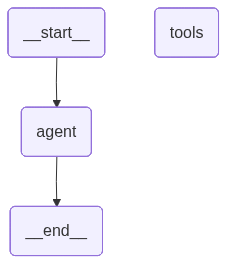

In [12]:
app